# Entrenar una CNN básica desde cero

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import layers, models
from get_dataset import load_dataset

%load_ext autoreload
%autoreload 2

2024-11-27 19:00:01.838509: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-27 19:00:01.847150: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-27 19:00:01.871588: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732744801.912708   38809 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732744801.925394   38809 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-27 19:00:01.987973: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

2024-11-27 19:00:18.408612: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-11-27 19:00:19.011481: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:370] TFRecordDataset `buffer_size` is unspecified, default to 262144


(450, 600, 3)
(450, 600, 3) tf.Tensor(b'nv', shape=(), dtype=string)


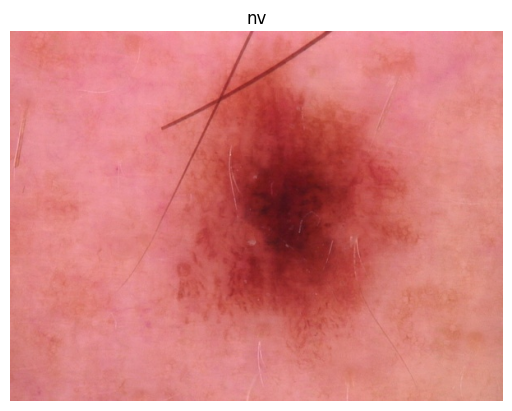

(450, 600, 3) tf.Tensor(b'nv', shape=(), dtype=string)


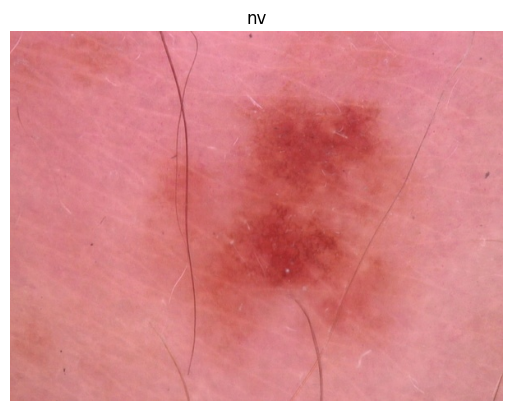

(450, 600, 3) tf.Tensor(b'nv', shape=(), dtype=string)


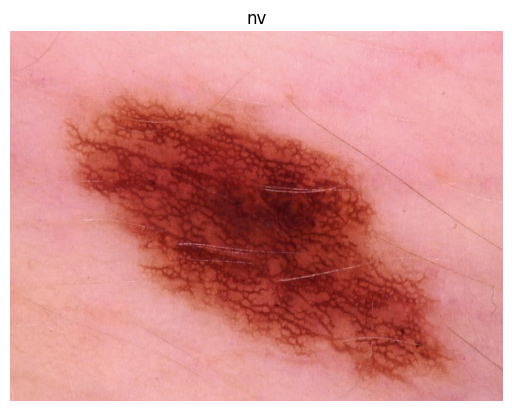

(450, 600, 3) tf.Tensor(b'nv', shape=(), dtype=string)


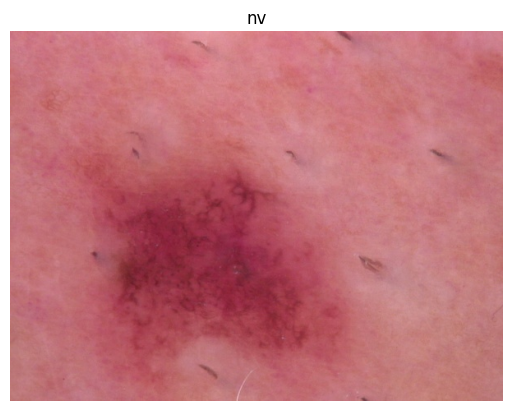

(450, 600, 3) tf.Tensor(b'mel', shape=(), dtype=string)


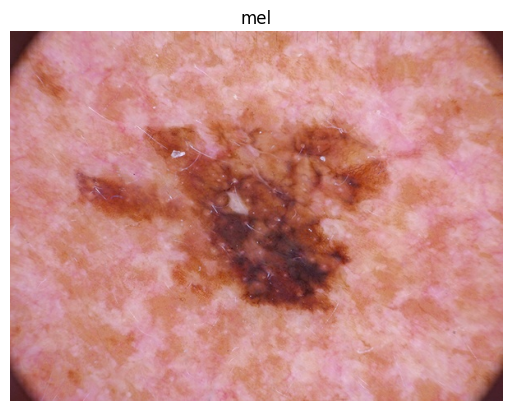

2024-11-27 19:00:22.857560: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [2]:
show_examples = True

# Load dataset
tfrecord_file = "train_img_mask_label_id.tfrecord"
dataset = load_dataset(tfrecord_file)
dataset = dataset.map(lambda x : (x["image"], x["label"])) # Now, dataset contains only images and labels as tuples
img_shape = next(iter(dataset))[0].shape
print(img_shape)

if show_examples:
    for image, label in dataset.take(5):
        print(image.shape, label)
        plt.imshow(image.numpy())
        plt.axis('off')
        plt.title(label.numpy().decode("utf-8"))
        plt.show()

2024-11-27 19:01:35.254853: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


(450, 600, 3) 3


2024-11-27 19:02:05.850292: W tensorflow/core/framework/op_kernel.cc:1818] OP_REQUIRES failed at cast_op.cc:122 : UNIMPLEMENTED: Cast int64 to string is not supported


UnimplementedError: Exception encountered when calling StringLookup.call().

[1m{{function_node __wrapped__Cast_device_/job:localhost/replica:0/task:0/device:CPU:0}} Cast int64 to string is not supported [Op:Cast] name: [0m

Arguments received by StringLookup.call():
  • inputs=np.int64(3)

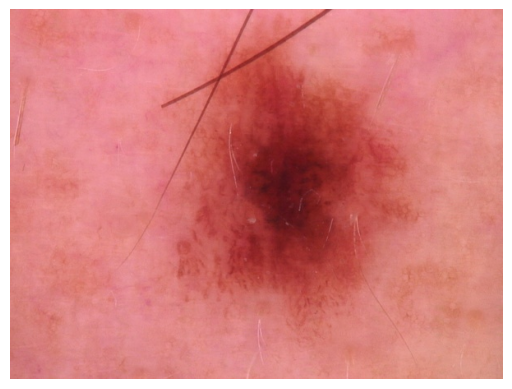

In [3]:
# Step 1: Extract labels and create a StringLookup layer
labels = [label.decode('utf-8') for _, label in dataset.as_numpy_iterator()]
unique_labels = set(labels)
string_lookup = layers.StringLookup(vocabulary=list(unique_labels))

# Step 2: Define a function to map labels to indices using StringLookup
def map_label_to_index(image, label):
    label = string_lookup(label)
    return image, label

# Step 3: Apply the mapping function to the dataset
mapped_dataset = dataset.map(map_label_to_index)

# Step 4: Verify the transformation
if show_examples:
    for image, label in mapped_dataset.take(5):
        print(image.shape, label.numpy())
        plt.imshow(image.numpy())
        plt.axis('off')
        plt.title(string_lookup(label.numpy()).decode("utf-8"))
        plt.show()


In [4]:
# Step 4: Shuffle and split dataset
total_samples = len(labels)
dataset = dataset.shuffle(buffer_size=1000, reshuffle_each_iteration=True)
train_size = int(0.8 * total_samples)
train_dataset = dataset.take(train_size).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = dataset.skip(train_size).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
# # Step 5: Data augmentation using Keras layers
# data_augmentation = models.Sequential([
#     layers.RandomFlip("horizontal_and_vertical"),
#     layers.RandomRotation(0.2),
#     layers.RandomZoom(0.2),
# ])

# def augment_data(image, label):
#     image = data_augmentation(image)
#     return image, label

# train_dataset = train_dataset.map(augment_data)

In [5]:
# Step 6: Build a simple CNN model
model = models.Sequential([
    layers.Input(shape=img_shape),
    layers.Conv2D(32, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dense(len(unique_labels), activation="softmax"),  # One output per class
])
model.summary()

2024-11-27 19:02:14.790843: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 538312704 exceeds 10% of free system memory.
2024-11-27 19:02:16.398469: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 538312704 exceeds 10% of free system memory.
2024-11-27 19:02:16.966736: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 538312704 exceeds 10% of free system memory.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 448, 598, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 224, 299, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 222, 297, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 111, 148, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1051392)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │   134,578,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,598,599 (513.45 MB)

 Trainable params: 134,598,599 (513.45 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
type(next(iter(train_dataset))[1])

In [6]:
# Step 7: Compile the model
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
              

# Step 8: Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
)

Epoch 1/10


2024-11-27 19:02:29.799727: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 538312704 exceeds 10% of free system memory.
2024-11-27 19:02:31.698656: W tensorflow/core/framework/op_kernel.cc:1818] OP_REQUIRES failed at cast_op.cc:122 : UNIMPLEMENTED: Cast string to float is not supported


UnimplementedError: Graph execution error:

Detected at node compile_loss/sparse_categorical_crossentropy/Cast defined at (most recent call last):
  File "/home/gonzagrau/miniconda3/envs/turco/lib/python3.11/runpy.py", line 198, in _run_module_as_main

  File "/home/gonzagrau/miniconda3/envs/turco/lib/python3.11/runpy.py", line 88, in _run_code

  File "/home/gonzagrau/miniconda3/envs/turco/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/home/gonzagrau/miniconda3/envs/turco/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/gonzagrau/miniconda3/envs/turco/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/gonzagrau/miniconda3/envs/turco/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/home/gonzagrau/miniconda3/envs/turco/lib/python3.11/asyncio/base_events.py", line 608, in run_forever

  File "/home/gonzagrau/miniconda3/envs/turco/lib/python3.11/asyncio/base_events.py", line 1936, in _run_once

  File "/home/gonzagrau/miniconda3/envs/turco/lib/python3.11/asyncio/events.py", line 84, in _run

  File "/home/gonzagrau/miniconda3/envs/turco/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/home/gonzagrau/miniconda3/envs/turco/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/home/gonzagrau/miniconda3/envs/turco/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/home/gonzagrau/miniconda3/envs/turco/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/home/gonzagrau/miniconda3/envs/turco/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/home/gonzagrau/miniconda3/envs/turco/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/home/gonzagrau/miniconda3/envs/turco/lib/python3.11/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/gonzagrau/miniconda3/envs/turco/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/home/gonzagrau/miniconda3/envs/turco/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/home/gonzagrau/miniconda3/envs/turco/lib/python3.11/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/home/gonzagrau/miniconda3/envs/turco/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/home/gonzagrau/miniconda3/envs/turco/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/home/gonzagrau/miniconda3/envs/turco/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/tmp/ipykernel_38809/4072631242.py", line 8, in <module>

  File "/home/gonzagrau/miniconda3/envs/turco/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/gonzagrau/miniconda3/envs/turco/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 368, in fit

  File "/home/gonzagrau/miniconda3/envs/turco/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 216, in function

  File "/home/gonzagrau/miniconda3/envs/turco/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 129, in multi_step_on_iterator

  File "/home/gonzagrau/miniconda3/envs/turco/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 110, in one_step_on_data

  File "/home/gonzagrau/miniconda3/envs/turco/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 59, in train_step

  File "/home/gonzagrau/miniconda3/envs/turco/lib/python3.11/site-packages/keras/src/trainers/trainer.py", line 399, in _compute_loss

  File "/home/gonzagrau/miniconda3/envs/turco/lib/python3.11/site-packages/keras/src/trainers/trainer.py", line 367, in compute_loss

  File "/home/gonzagrau/miniconda3/envs/turco/lib/python3.11/site-packages/keras/src/trainers/compile_utils.py", line 692, in __call__

  File "/home/gonzagrau/miniconda3/envs/turco/lib/python3.11/site-packages/keras/src/trainers/compile_utils.py", line 701, in call

  File "/home/gonzagrau/miniconda3/envs/turco/lib/python3.11/site-packages/keras/src/losses/loss.py", line 63, in __call__

  File "/home/gonzagrau/miniconda3/envs/turco/lib/python3.11/site-packages/keras/src/tree/tree_api.py", line 174, in map_structure

  File "/home/gonzagrau/miniconda3/envs/turco/lib/python3.11/site-packages/keras/src/tree/optree_impl.py", line 98, in map_structure

  File "/home/gonzagrau/miniconda3/envs/turco/lib/python3.11/site-packages/optree/ops.py", line 752, in tree_map

  File "/home/gonzagrau/miniconda3/envs/turco/lib/python3.11/site-packages/keras/src/losses/loss.py", line 64, in <lambda>

  File "/home/gonzagrau/miniconda3/envs/turco/lib/python3.11/site-packages/keras/src/ops/core.py", line 952, in convert_to_tensor

  File "/home/gonzagrau/miniconda3/envs/turco/lib/python3.11/site-packages/keras/src/backend/tensorflow/core.py", line 150, in convert_to_tensor

Cast string to float is not supported
	 [[{{node compile_loss/sparse_categorical_crossentropy/Cast}}]] [Op:__inference_multi_step_on_iterator_21748]